# Install packages

In [2]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.6 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-4buvs2vt
  Running command

In [ ]:
! python --version

Python 3.11.12


## Login huggingface (for uploading/downloading Llama)

In [3]:
from huggingface_hub import login

login(token=token, add_to_git_credential=True)

In [ ]:
# Check GPU availability
import torch
print("Processing Unit:", "cuda" if torch.cuda.is_available() else "cpu")

Processing Unit: cuda


# Benchmarking with pre-trained model only

## Load pre-trained model for benchmarking without fine-tuning

In [ ]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf",
                                             return_dict=True,
                                             load_in_8bit=True,
                                             device_map={"": device},
                                             llm_int8_enable_fp32_cpu_offload=True
                                             )
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

## Load test data

In [ ]:
# Get test data
import pandas as pd

splits = {'train': 'train.tsv', 'test': 'test.tsv'}
# Load test_data
test_data = pd.read_csv("hf://datasets/Zakia/drugscom_reviews/" + splits["test"], sep="\t")
test_data.drop(columns=['Unnamed: 0'], inplace=True)

# Preprocess training data
test_data = test_data.dropna(subset=['review', 'rating'])
test_data['sentiment'] = test_data['rating'].apply(lambda x: 'negative' if x < 5 else ('neutral' if 5 <= x <= 6 else 'positive'))

# Select 100 records of each label for balanced training dataset
test_data = pd.concat([
    test_data[test_data["sentiment"] == "positive"].sample(n=200, random_state=42),
    test_data[test_data["sentiment"] == "negative"].sample(n=200, random_state=42),
    test_data[test_data["sentiment"] == "neutral"].sample(n=200, random_state=42)
]).reset_index(drop=True)

def generate_test_prompt(data_point):
    return f"""
            Analyze the sentiment of the medicine reviews enclosed in square brackets,
            determine if it is positive, neutral, or negative, and return the answer as
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["review"]}] = """.strip()

# Row "prediction" contains training data, while row "prompt" contains prompt to send to model
for index, row in test_data.iterrows():
  test_data.loc[index, 'prompt'] = generate_test_prompt(row)

test_data.head()

,drugName,condition,review,rating,date,usefulCount,sentiment,prompt
0,Ortho Evra,Birth Control,"""When I first went to the doctor I was not int...",9.0,"May 22, 2014",53,positive,Analyze the sentiment of the medicine reviews ...
1,Escitalopram,Generalized Anxiety Disorde,"""7 years ago I was diagnosed with leukaemia an...",10.0,"December 2, 2015",11,positive,Analyze the sentiment of the medicine reviews ...
2,Amphetamine / dextroamphetamine,ADHD,"""Great medication. I was doing tasks again and...",9.0,"September 14, 2013",26,positive,Analyze the sentiment of the medicine reviews ...
3,Testosterone,"Hypogonadism, Male","""I started 60 mg of Axiron on 30 Oct it is now...",10.0,"November 12, 2013",60,positive,Analyze the sentiment of the medicine reviews ...
4,Amitriptyline,Interstitial Cystitis,"""I was put on this medication for interstitial...",10.0,"January 12, 2017",12,positive,Analyze the sentiment of the medicine reviews ...


## Benchmarking with pre-trained model
Runtime: 4 minutes

<ipython-input-9-1544e6933466>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


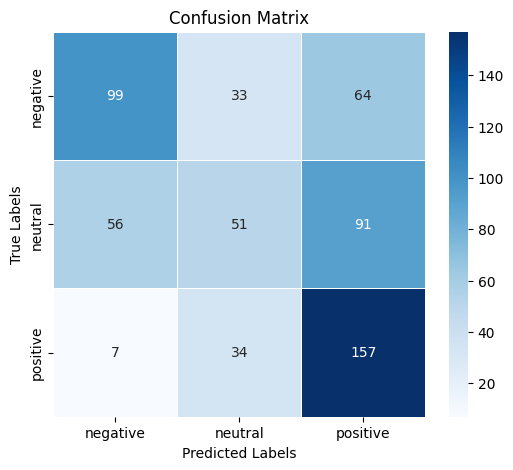

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import re

def string_diff(base, full):
    if full.startswith(base):
        return full[len(base):]
    return None  # or raise an exception / return full if no prefix match

def extract_word(text):
    match = re.search(r"[a-zA-Z]+", text)
    if match:
        return match.group(0)
    return None  # or handle the case where no word is found

def replace_none(data_list, replacement_text):
    return [replacement_text if x is None else x for x in data_list]

pred = []
outputs = []
for test in test_data.iterrows():
  prompt = test[1]["prompt"]
  batch = tokenizer(prompt, return_tensors='pt').to(device)

  with torch.cuda.amp.autocast():
    output_tokens = model.generate(**batch, max_new_tokens=3, do_sample=True)

  output = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
  outputs.append(output)
  pred.append(extract_word(string_diff(prompt, output).strip()))

# Replace None-values to neutral
pred = replace_none(pred, 'neutral')

# Example lists (Replace these with actual values)
true_labels = test_data['sentiment'].tolist()  # Convert to list if it's a pandas Series
# prediction already initialized in previous block

# Define class labels
class_labels = ["negative", "neutral", "positive"]

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred, labels=class_labels)

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import numpy as np

# Number of classes
num_classes = cm.shape[0]

# Accuracy
accuracy = np.trace(cm) / np.sum(cm)

# Precision, Recall, F1-Score for each class
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
f1_score = np.zeros(num_classes)

for i in range(num_classes):
    tp = cm[i, i]  # True Positives
    fp = np.sum(cm[:, i]) - tp  # False Positives
    fn = np.sum(cm[i, :]) - tp  # False Negatives

    precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

# Print results
print("Before fine-tuning:")
print(f"Accuracy: {accuracy:.4f}")
for i in range(num_classes):
    print(f"Class '{class_labels[i]}': Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-Score: {f1_score[i]:.4f}")


Before fine-tuning:
Accuracy: 0.5186
Class 'negative': Precision: 0.6111, Recall: 0.5051, F1-Score: 0.5531
Class 'neutral': Precision: 0.4322, Recall: 0.2576, F1-Score: 0.3228
Class 'positive': Precision: 0.5032, Recall: 0.7929, F1-Score: 0.6157


## Test with any specific case

In [ ]:
# Change "test" variable to select another test. Varies from 0 to 599
test = 0
prompt = test_data.iloc[test]["prompt"]
batch = tokenizer(prompt, return_tensors='pt').to(device)

with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=3, do_sample=False)

output = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
print(extract_word(string_diff(prompt, output).strip()))

<ipython-input-11-39034aa054ce>:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


positive


# Fine-tune Llama-7b-hf

## Load train data

In [4]:
# Get training data
import pandas as pd

splits = {'train': 'train.tsv', 'test': 'test.tsv'}
train_data = pd.read_csv("hf://datasets/Zakia/drugscom_reviews/" + splits["train"], sep="\t")
train_data.drop(columns=['Unnamed: 0'], inplace=True)

# Preprocess training data
train_data = train_data.dropna(subset=['review', 'rating'])
train_data['sentiment'] = train_data['rating'].apply(lambda x: 'negative' if x < 5 else ('neutral' if 5 <= x <= 6 else 'positive'))

# Select 100 records of each label for balanced training dataset
train_data = pd.concat([
    train_data[train_data["sentiment"] == "positive"].sample(n=100, random_state=42),
    train_data[train_data["sentiment"] == "negative"].sample(n=100, random_state=42),
    train_data[train_data["sentiment"] == "neutral"].sample(n=100, random_state=42)
]).reset_index(drop=True)

def generate_prompt(data_point):
    return f"""
            Analyze the sentiment of the medicine reviews enclosed in square brackets,
            determine if it is positive, neutral, or negative, and return the answer as
            the corresponding sentiment label.

            [{data_point["review"]}] = {data_point["sentiment"]}""".strip()

def generate_test_prompt(data_point):
    return f"""
            Analyze the sentiment of the medicine reviews enclosed in square brackets,
            determine if it is positive, neutral, or negative, and return the answer as
            the corresponding sentiment label.

            [{data_point["review"]}] = """.strip()

# Row "prediction" contains training data, while row "prompt" contains prompt to send to model
for index, row in train_data.iterrows():
  train_data.loc[index, 'prediction'] = generate_prompt(row)
  train_data.loc[index, 'prompt'] = generate_test_prompt(row)

train_data = train_data[["prediction", "prompt", "sentiment"]]
train_data.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,prediction,prompt,sentiment
0,Analyze the sentiment of the medicine reviews ...,Analyze the sentiment of the medicine reviews ...,positive
1,Analyze the sentiment of the medicine reviews ...,Analyze the sentiment of the medicine reviews ...,positive
2,Analyze the sentiment of the medicine reviews ...,Analyze the sentiment of the medicine reviews ...,positive
3,Analyze the sentiment of the medicine reviews ...,Analyze the sentiment of the medicine reviews ...,positive
4,Analyze the sentiment of the medicine reviews ...,Analyze the sentiment of the medicine reviews ...,positive


## Load pre-trained model Llama-2 7b for fine-tuning

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_8bit=True
)

model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-hf",
    quantization_config=quantization_config,
    device_map='auto',
)

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

## Freeze the model weights (for faster fine-tuning)

In [6]:
# Freeze the model weights
for param in model.parameters():
  param.requires_grad = False
  if param.ndim == 1:
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [7]:
def print_trainable_parameters(model):
  """
  Prints the number of trainable parameters in the model.
  """
  trainable_params = 0
  all_param = 0
  for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
      trainable_params += param.numel()
  print(
      f"trainable params: {trainable_params} || all params: {all_param} || trainable: {100 * trainable_params / all_param}%"
  )

# LoRA adapters
from peft import LoraConfig, get_peft_model
from datasets import Dataset

config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Convert train dataset to (Datasets) format - Ready for training
train_dataset = Dataset.from_pandas(train_data)
train_dataset = train_dataset.map(lambda samples: tokenizer(samples['prediction']), batched=True)

trainable params: 8388608 || all params: 6746804224 || trainable: 0.12433454005023165%


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

## Fine-tuning Llama-7b-hf

Training time:

In [8]:
import transformers

# Setup pad_token
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id

# Fine-tune the model
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_dataset,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=10,
        max_steps=50,
        learning_rate=5e-5,
        fp16=True,
        logging_steps=1,
        output_dir='outputs'
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dotruongthanhan to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss
1,2.548400
2,2.510600
3,2.660600
4,2.536100
5,2.478300
6,2.562700
7,2.502000
8,2.429100
9,2.356000
10,2.468600


TrainOutput(global_step=50, training_loss=2.1618918204307556, metrics={'train_runtime': 1758.3343, 'train_samples_per_second': 0.455, 'train_steps_per_second': 0.028, 'total_flos': 7604493099270144.0, 'train_loss': 2.1618918204307556, 'epoch': 2.64})

## Store trained LoRA parameters to huggingface (quicker retrieval for testing)

In [9]:
# Upload LoRA weights to huggingface
model.push_to_hub("dotruongthanhan/llama-2-7b-sentiment-analysis",
                  use_auth_token=True,
                  commi_messaage="basic training",
                  private=True)

/usr/local/lib/python3.11/dist-packages/transformers/utils/hub.py:907: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dotruongthanhan/llama-2-7b-sentiment-analysis/commit/5e560527043885e7c386758f20859510a20285f2', commit_message='Upload model', commit_description='', oid='5e560527043885e7c386758f20859510a20285f2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/dotruongthanhan/llama-2-7b-sentiment-analysis', endpoint='https://huggingface.co', repo_type='model', repo_id='dotruongthanhan/llama-2-7b-sentiment-analysis'), pr_revision=None, pr_num=None)

# Benchmarking with fine-tuned model

## Load test data

In [10]:
# Get training data
import pandas as pd

splits = {'train': 'train.tsv', 'test': 'test.tsv'}

# Load test_data
test_data = pd.read_csv("hf://datasets/Zakia/drugscom_reviews/" + splits["test"], sep="\t")
test_data.drop(columns=['Unnamed: 0'], inplace=True)

# Preprocess training data
test_data = test_data.dropna(subset=['review', 'rating'])
test_data['sentiment'] = test_data['rating'].apply(lambda x: 'negative' if x < 5 else ('neutral' if 5 <= x <= 6 else 'positive'))

# Select 100 records of each label for balanced training dataset
test_data = pd.concat([
    test_data[test_data["sentiment"] == "positive"].sample(n=200, random_state=42),
    test_data[test_data["sentiment"] == "negative"].sample(n=200, random_state=42),
    test_data[test_data["sentiment"] == "neutral"].sample(n=200, random_state=42)
]).reset_index(drop=True)

def generate_test_prompt(data_point):
    return f"""
            Analyze the sentiment of the medicine reviews enclosed in square brackets,
            determine if it is positive, neutral, or negative, and return the answer as
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["review"]}] = """.strip()

# Row "prediction" contains training data, while row "prompt" contains prompt to send to model
for index, row in test_data.iterrows():
  test_data.loc[index, 'prompt'] = generate_test_prompt(row)

test_data.head()

,drugName,condition,review,rating,date,usefulCount,sentiment,prompt
0,Ortho Evra,Birth Control,"""When I first went to the doctor I was not int...",9.0,"May 22, 2014",53,positive,Analyze the sentiment of the medicine reviews ...
1,Escitalopram,Generalized Anxiety Disorde,"""7 years ago I was diagnosed with leukaemia an...",10.0,"December 2, 2015",11,positive,Analyze the sentiment of the medicine reviews ...
2,Amphetamine / dextroamphetamine,ADHD,"""Great medication. I was doing tasks again and...",9.0,"September 14, 2013",26,positive,Analyze the sentiment of the medicine reviews ...
3,Testosterone,"Hypogonadism, Male","""I started 60 mg of Axiron on 30 Oct it is now...",10.0,"November 12, 2013",60,positive,Analyze the sentiment of the medicine reviews ...
4,Amitriptyline,Interstitial Cystitis,"""I was put on this medication for interstitial...",10.0,"January 12, 2017",12,positive,Analyze the sentiment of the medicine reviews ...


## Download the fine-tuned parameters and pre-trained model

In [11]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = "dotruongthanhan/llama-2-7b-sentiment-analysis"
config = PeftConfig.from_pretrained(peft_model_id)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path,
                                             return_dict=True,
                                             load_in_8bit=True,
                                             device_map={"": device},
                                             llm_int8_enable_fp32_cpu_offload=True
                                             )
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
fine_tuned_model = PeftModel.from_pretrained(model, peft_model_id)

adapter_config.json:   0%|          | 0.00/780 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

## Benchmarking with fine-tuned model

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import re

def string_diff(base, full):
    # if full.startswith(base):
      return full[len(base):]
    # return None  # or raise an exception / return full if no prefix match

def extract_word(text):
    match = re.search(r"[a-zA-Z]+", text)
    if match:
        return match.group(0)
    return None  # or handle the case where no word is found

def replace_none(data_list, replacement_text):
    return [replacement_text if x is None else x for x in data_list]

<ipython-input-13-800b56127652>:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


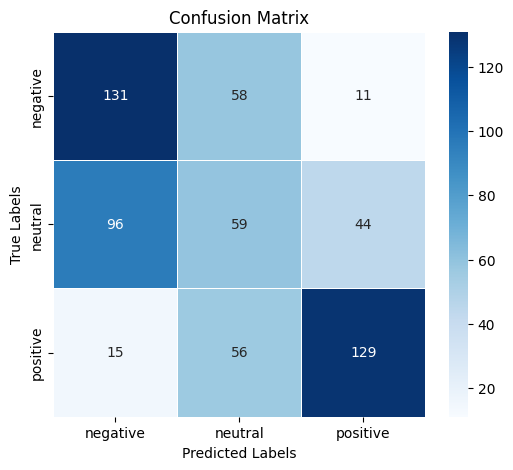

After fine-tuning:
Accuracy: 0.5326
Class 'negative': Precision: 0.5413, Recall: 0.6550, F1-Score: 0.5928
Class 'neutral': Precision: 0.3410, Recall: 0.2965, F1-Score: 0.3172
Class 'positive': Precision: 0.7011, Recall: 0.6450, F1-Score: 0.6719


In [13]:
import numpy as np

pred = []
for test in test_data.iterrows():
  prompt = test[1]["prompt"]
  batch = tokenizer(prompt, return_tensors='pt').to(device)

  with torch.cuda.amp.autocast():
    output_tokens = model.generate(**batch, max_new_tokens=3, do_sample=True)

  output = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
  pred.append(extract_word(string_diff(prompt, output).strip()))

# Replace None-values with neutral
pred = replace_none(pred, 'neutral')

# Example lists (Replace these with actual values)
true_labels = test_data['sentiment'].tolist()  # Convert to list if it's a pandas Series

# Define class labels
class_labels = ["negative", "neutral", "positive"]

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred, labels=class_labels)

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Number of classes
num_classes = cm.shape[0]

# Accuracy
accuracy = np.trace(cm) / np.sum(cm)

# Precision, Recall, F1-Score for each class
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
f1_score = np.zeros(num_classes)

for i in range(num_classes):
    tp = cm[i, i]  # True Positives
    fp = np.sum(cm[:, i]) - tp  # False Positives
    fn = np.sum(cm[i, :]) - tp  # False Negatives

    precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

# Print results
print("After fine-tuning:")
print(f"Accuracy: {accuracy:.4f}")
for i in range(num_classes):
    print(f"Class '{class_labels[i]}': Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-Score: {f1_score[i]:.4f}")


### Test with 1 specific case

In [14]:
# Change "test" variable to select another test. Varies from 0 to 599
test = 250
prompt = test_data.iloc[test]["prompt"]
batch = tokenizer(prompt, return_tensors='pt').to(device)

with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=3, do_sample=True)

output = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
result = extract_word(string_diff(prompt, output).strip())
print(result)

<ipython-input-14-9af9ea2b4a04>:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


neutral


In [15]:
from importlib.metadata import version

packages = ['huggingface_hub', 'torch', 'peft', 'transformers', 'pandas', 'seaborn', 'matplotlib', 'scikit-learn', 'regex', 'bitsandbytes', 'datasets']
for package in packages:
  print(f"Package {package}: Version {version(package)}")

Package huggingface_hub: Version 0.31.2
Package torch: Version 2.6.0+cu124
Package peft: Version 0.15.2.dev0
Package transformers: Version 4.53.0.dev0
Package pandas: Version 2.2.2
Package seaborn: Version 0.13.2
Package matplotlib: Version 3.10.0
Package scikit-learn: Version 1.6.1
Package regex: Version 2024.11.6
Package bitsandbytes: Version 0.45.5
Package datasets: Version 2.14.4
